In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pennylane
!git clone https://github.com/PennyLaneAI/pennylane-lightning.git
import os
os.chdir("pennylane-lightning")
!pip install -r requirements.txt
!PL_BACKEND="lightning_qubit" pip install -e . -vv
!python -m pip install wheel custatevec-cu11
import os
import site
os.environ["CUQUANTUM_SDK"] = f'{site.getsitepackages()[0]}/cuquantum/lib'
!PL_BACKEND="lightning_gpu" python -m pip install -e . -vv
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F

import pennylane as qml
from pennylane import numpy as np

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.6 MB/s eta 0:00:00
Cloning into 'pennylane-lightning'...
remote: Enumerating objects: 29843, done.
remote: Counting objects: 100% (4064/4064), done.
remote: Compressing objects: 100% (1144/1144), done.
remote: Total 29843 (delta 3238), reused 3608 (delta 2920), pack-reused 25779
Receiving objects: 100% (29843/29843), 8.45 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (23323/23323), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.8/238.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.0/334.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.2 MB/s eta 0:00

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt


torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [4]:
n_qubits = 4
if use_cuda is True:
    dev = qml.device("lightning.gpu", wires=n_qubits)
else:
    dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

print(f"{dev=}")

input = torch.from_numpy(np.random.uniform(0, np.pi, (4,))).to(device)
weights = torch.from_numpy(np.random.uniform(0, np.pi, (4, 4))).to(device)
output = circuit(input, weights)
print(f"{output=}")

dev=<default.qubit device (wires=4) at 0x7c1edc842020>
output=[tensor(0.3381, dtype=torch.float64), tensor(0.2435, dtype=torch.float64), tensor(-0.0542, dtype=torch.float64), tensor(0.1571, dtype=torch.float64)]


In [5]:
#Setting of the main hyper-parameters of the model
batch_size = 200
#n_train = batch_size * 125    # Size of the train dataset
#n_test = batch_size * 25     # Size of the test dataset
n_channels = 4
initial_lr = 0.003          # Define your initial learning rate
num_epochs = 40

In [6]:
def quanv(image, weights):
    """Convolves the input image with many applications of the same quantum circuit."""
    # PyTorch models generally require a 4D input tensor with the
    # dimensions - (batch size, channels, height, width)
    # input image shape is (batch_size, 1, 14, 14)
    # output shape should be (batch_size, 4, 7, 7)
    batch_size = image.shape[0]
    out = np.zeros((batch_size, 4, 7, 7))
    l_image = image.detach().cpu().numpy()
    l_weights = weights.detach().cpu().numpy()

    for i in range(batch_size):
        # Loop over the coordinates of the top-left pixel of 2X2 squares
        for j in range(0, 14, 2):
            for k in range(0, 14, 2):
                # Process a squared 2x2 region of the image with a quantum circuit
                q_results = circuit(
                    [
                        l_image[i, 0, j, k] * np.pi,
                        l_image[i, 0, j, k + 1] * np.pi,
                        l_image[i, 0, j + 1, k] * np.pi,
                        l_image[i, 0, j + 1, k + 1] * np.pi
                    ],
                    l_weights
                )
                # Assign expectation values to different channels of the output pixel (j/2, k/2)
                for c in range(n_channels):
                    out[i, c, j // 2, k // 2] = q_results[c]
    return out

In [7]:
# Custom nn.Module class for handling the quantum convolution
class QuantConv(nn.Module):

    # The number of layers in the BasicEntanglerLayers instance in
    # the quantum convolver
    LAYERS = 4

    def __init__(self):
        super(QuantConv, self).__init__()
        # Initialise and register weights
        # weights have shape (LAYERS, n_qubits) where LAYERS is the
        # number of layers in the BasicEntanglerLayers
        self.weights = nn.Parameter(
            torch.from_numpy(np.random.uniform(
                0, np.pi, (QuantConv.LAYERS, n_qubits)))).to(device)

    def forward(self, input):
        expectation_z = quanv(input, self.weights)
        x = torch.tensor(expectation_z).to(device)
        return x



class QuantModel(nn.Module):
    def __init__(self):
        super(QuantModel, self).__init__()
        self.qconv = QuantConv()
        self.fc1 = nn.Linear(4 * 7 * 7, 10)
        self.double()

    def forward(self, x):
        # Propagate the input through the CNN layers
        x = self.qconv(x)
        # Flatten the output from the convolutional layer
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        return x

def get_num_correct(pred, label):
    return pred.argmax(dim=1).eq(label).sum().item()

In [8]:
# Create an instance of the QuantModel
model = QuantModel()
model.to(device)

QuantModel(
  (qconv): QuantConv()
  (fc1): Linear(in_features=196, out_features=10, bias=True)
)

In [9]:
device = torch.device("cuda:0")
print(device)
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

cuda:0
Running on the CPU


In [10]:
mean = 0.2069
std = 0.1471

test_data_dir = '/content/drive/MyDrive/alweld/test'

transform_test = transforms.Compose([
     transforms.CenterCrop((800,800)),
     transforms.ToTensor(),
     ])

test_dataset = datasets.ImageFolder(root =test_data_dir,transform = transform_test)
test_dataset
original_labels_dict = test_dataset.class_to_idx

In [11]:
import json
# Opening JSON file
f = open('/content/drive/MyDrive/alweld/test/test.json',)

label_test = json.load(f)

In [12]:
keys_orig = list(label_test.keys())
values = list(label_test.values())
keys = []
for key in keys_orig:
  a_string = key
  a_string = a_string.replace("/", " ")
  x = a_string.split()
  string = x[0]+' '+x[1]
  keys.append(string)
true_test_labels_dict = {keys[i]: values[i] for i in range(len(keys))}
true_test_labels_dict

{'170906-143512-Al 2mm-part2': 1,
 '170904-155610-Al 2mm': 2,
 '170906-143512-Al 2mm-part1': 2,
 '170904-154202-Al 2mm-part1': 2,
 '170904-150144-Al 2mm-part2': 4,
 '170906-155007-Al 2mm-part2': 4,
 '170913-154448-Al 2mm': 0,
 '170906-113317-Al 2mm-part1': 0,
 '170905-112213-Al 2mm': 0,
 '170906-104925-Al 2mm': 0,
 '170904-152301-Al 2mm-part2': 5,
 '170906-153326-Al 2mm-part3': 3,
 '170906-151724-Al 2mm-part1': 3,
 '170906-155007-Al 2mm-part1': 3}

#6 class test


In [ ]:
#true_test_labels_dict2 = {}
#for key,value in true_test_labels_dict.items():
  #if value ==0:
    #val = 0
  #else:
    #val = 1
  #dict2 = {key:val}
  #true_test_labels_dict2.update(dict2)
#true_test_labels_dict2

{'170906-143512-Al 2mm-part2': 1,
 '170904-155610-Al 2mm': 1,
 '170906-143512-Al 2mm-part1': 1,
 '170904-154202-Al 2mm-part1': 1,
 '170904-150144-Al 2mm-part2': 1,
 '170906-155007-Al 2mm-part2': 1,
 '170913-154448-Al 2mm': 0,
 '170906-113317-Al 2mm-part1': 0,
 '170905-112213-Al 2mm': 0,
 '170906-104925-Al 2mm': 0,
 '170904-152301-Al 2mm-part2': 1,
 '170906-153326-Al 2mm-part3': 1,
 '170906-151724-Al 2mm-part1': 1,
 '170906-155007-Al 2mm-part1': 1}

In [13]:
test_label_map_dict = {}

for key,value in original_labels_dict.items():
  test_label_map_dict.update({value:true_test_labels_dict[key]})
test_label_map_dict

{0: 4,
 1: 5,
 2: 2,
 3: 2,
 4: 0,
 5: 0,
 6: 0,
 7: 2,
 8: 1,
 9: 3,
 10: 3,
 11: 3,
 12: 4,
 13: 0}

#6 class test

In [14]:
PATH_model = "/content/drive/My Drive/modelv6.pt"
# torch.save(model.state_dict(),PATH_model)

In [15]:
#net = Network()
model = QuantModel()
net = model
pretrained_dict = torch.load(PATH_model, map_location=device)

# Filter out layers with mismatched shapes
model_dict = net.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.shape == model_dict[k].shape}

# Update the model's state dictionary
model_dict.update(pretrained_dict)
net.load_state_dict(model_dict)
net.to(device)

QuantModel(
  (qconv): QuantConv()
  (fc1): Linear(in_features=196, out_features=10, bias=True)
)

In [16]:
torch.cuda.empty_cache()
torch.set_grad_enabled(False)

#6 class test


In [17]:
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

In [18]:
def get_num_correct2(pred,true):
  prediction = pred.argmax(dim=1)
  label = []
  for val in prediction:
    if val.item() ==0:
      label.append(0)
    else:
      label.append(1)

  n = len(true)
  correct = 0
  for x in range(n):
      if true[x] == label[x]:
          correct += 1
  return correct

In [19]:
total_correct=0
correct_predictions = []
i=0
total = 0
for batch in test_loader:
  image, label_original = batch
  label = [test_label_map_dict[lab.item()] for lab in label_original]
  label = torch.tensor(label)


  pred = net(image.to(device))

  total_correct += get_num_correct2(pred,label.to(device))
  correct_predictions.append(total_correct)

  total += len(label)
  acc = 100*total_correct/(total)
  print('Batch No: ',i+1,'/',len(test_loader),', Accuracy till Now : ', acc)
  i=i+1
print(total_correct/len(test_dataset))

Batch No:  1 / 639 , Accuracy till Now :  0.0
Batch No:  2 / 639 , Accuracy till Now :  5.0
Batch No:  3 / 639 , Accuracy till Now :  3.3333333333333335
Batch No:  4 / 639 , Accuracy till Now :  7.5
Batch No:  5 / 639 , Accuracy till Now :  8.0
Batch No:  6 / 639 , Accuracy till Now :  6.666666666666667
Batch No:  7 / 639 , Accuracy till Now :  7.142857142857143
Batch No:  8 / 639 , Accuracy till Now :  6.25
Batch No:  9 / 639 , Accuracy till Now :  6.666666666666667
Batch No:  10 / 639 , Accuracy till Now :  6.0
Batch No:  11 / 639 , Accuracy till Now :  5.454545454545454
Batch No:  12 / 639 , Accuracy till Now :  5.0
Batch No:  13 / 639 , Accuracy till Now :  5.384615384615385
Batch No:  14 / 639 , Accuracy till Now :  5.714285714285714
Batch No:  15 / 639 , Accuracy till Now :  5.333333333333333
Batch No:  16 / 639 , Accuracy till Now :  5.0
Batch No:  17 / 639 , Accuracy till Now :  4.705882352941177
Batch No:  18 / 639 , Accuracy till Now :  4.444444444444445
Batch No:  19 / 639 ,

In [20]:
test_loader1 = DataLoader(test_dataset, batch_size=10,shuffle=True)

total_correct=0
condition = True
for batch in test_loader1:
  if condition:
    image, label_original = batch
    label = [test_label_map_dict[lab.item()] for lab in label_original]
    label = torch.tensor(label)


    pred = net(image.to(device))

    total_correct += get_num_correct(pred,label.to(device))

    condition = False
  else:
    break
label_6class = label
pred_6class = pred.argmax(dim=1)

In [21]:
weld_type = {
    0: 'Good Weld',
    1: 'Defective Weld',
    2: 'Defective Weld',
    3: 'Defective Weld',
    4:'Defective Weld',
    5:'Defective Weld'
}

In [22]:
defect_label = {
    0: 'Good Weld',
    1: ' Burn through',
    2: 'Contamination',
    3: 'Lack of fusion',
    4:'Misalignment',
    5:'Lack of penetration'
}

=> Image No : 1
 Type of Weld : Defective Weld
 Actual Defect : Misalignment
 Predicted Defect :  Lack of penetration


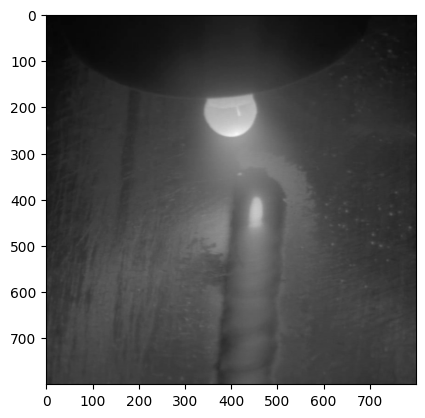

-------------------xxxx--------------------------
=> Image No : 2
 Type of Weld : Defective Weld
 Actual Defect :  Burn through
 Predicted Defect :  Lack of penetration


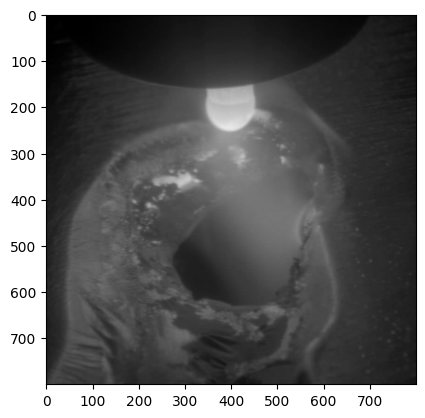

-------------------xxxx--------------------------
=> Image No : 3
 Type of Weld : Defective Weld
 Actual Defect : Contamination
 Predicted Defect :   Burn through


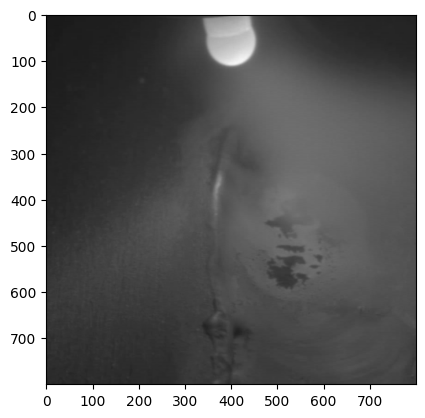

-------------------xxxx--------------------------
=> Image No : 4
 Type of Weld : Good Weld
 Actual Defect : Good Weld
 Predicted Defect :  Lack of penetration


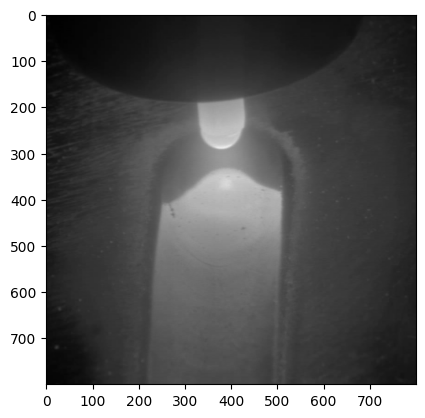

-------------------xxxx--------------------------
=> Image No : 5
 Type of Weld : Defective Weld
 Actual Defect : Contamination
 Predicted Defect :  Lack of penetration


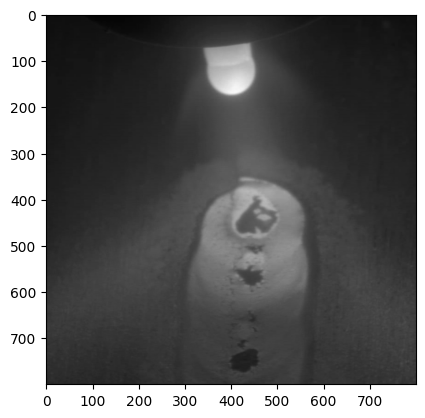

-------------------xxxx--------------------------
=> Image No : 6
 Type of Weld : Defective Weld
 Actual Defect : Contamination
 Predicted Defect :   Burn through


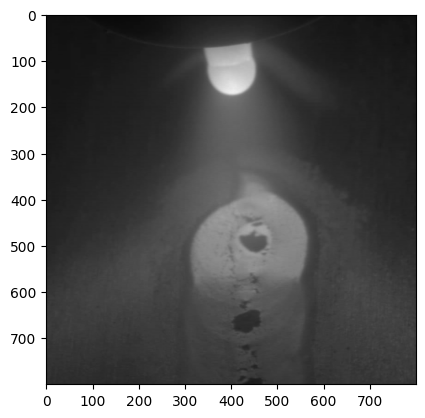

-------------------xxxx--------------------------
=> Image No : 7
 Type of Weld : Defective Weld
 Actual Defect : Contamination
 Predicted Defect :   Burn through


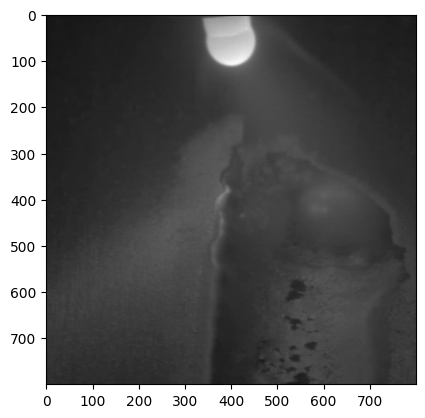

-------------------xxxx--------------------------
=> Image No : 8
 Type of Weld : Good Weld
 Actual Defect : Good Weld
 Predicted Defect :  Lack of penetration


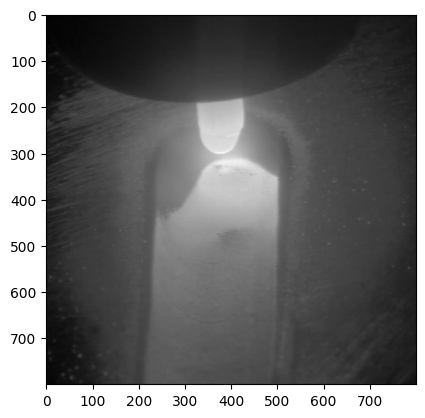

-------------------xxxx--------------------------
=> Image No : 9
 Type of Weld : Defective Weld
 Actual Defect : Contamination
 Predicted Defect :  Lack of penetration


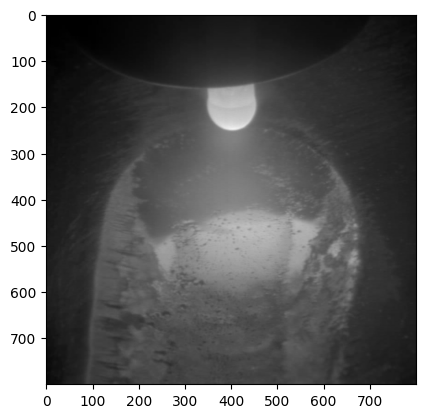

-------------------xxxx--------------------------
=> Image No : 10
 Type of Weld : Defective Weld
 Actual Defect : Lack of fusion
 Predicted Defect :  Lack of penetration


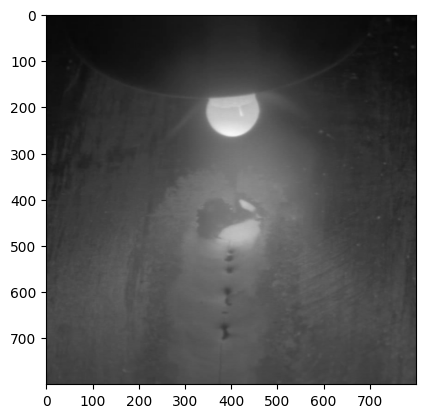

-------------------xxxx--------------------------


In [23]:
for i in range(len(pred_6class)):
  print('=> Image No :',i+1)
  img= image[i]
  print(' Type of Weld :', weld_type[label_6class[i].item()])
  print(' Actual Defect :', defect_label[label_6class[i].item()])
  print(' Predicted Defect : ',defect_label[pred_6class[i].item()])
  plt.imshow(  img.permute(1, 2, 0)  )
  plt.show()
  print('-------------------xxxx--------------------------')

In [ ]:
# class Network(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.features = nn.Sequential(
#             nn.MaxPool2d(kernel_size=2),
#             nn.Conv2d(3, 32, kernel_size=5, stride=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p = 0.1),

#             nn.MaxPool2d(kernel_size=2),
#             nn.Conv2d(32, 64, kernel_size=5, stride=2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p = 0.2),

#             nn.MaxPool2d(kernel_size=2),
#             nn.Conv2d(64, 128, kernel_size=5),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p = 0.2),

#             nn.MaxPool2d(kernel_size=2),
#             nn.Conv2d(128,256, kernel_size=3),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#         )

#         self.classifier = nn.Sequential(
#             nn.Dropout(p = 0.2),
#             nn.Linear(16384, 256),
#             # nn.BatchNorm1d(256),
#             nn.ReLU(inplace=True),

#             nn.Dropout(p = 0.2),
#             nn.Linear(256, 128),
#             # nn.BatchNorm1d(128),
#             nn.ReLU(inplace=True),

#             nn.Dropout(p = 0.1),
#             nn.Linear(128, 6),
# #             nn.BatchNorm1d(512), not in this model
#             nn.Softmax(dim=1)
#         )



#     def forward(self, x):
#         x = self.features(x)
#         x = x.reshape(-1, 16384)
#         x = self.classifier(x)

#         return x

# def get_num_correct(pred, label):
#     return pred.argmax(dim=1).eq(label).sum().item()